In [1]:
!pip install pandas
!pip install scikit-learn
!pip install shap
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Social_Media_Advertising.csv")

c:\Users\Harsha\Documents\CODE\Social_Media_Advertising\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating Column Day_Duration ###

This new column will be created for turning duration strings into integers

In [3]:
df["Duration_Days"] = df["Duration"].str.extract("(\\d+)").astype(int)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days'],
      dtype='object')

In [4]:
df["Duration_Days"].head()

0    15
1    15
2    15
3    15
4    15
Name: Duration_Days, dtype: int64

### Creating Column Acquisition_Cost_Num ###

This new column will be created for turning Acquisiton strings into floats

In [5]:
df["Acquisition_Cost_Num"] = df["Acquisition_Cost"].replace("[$,]", "", regex=True).astype(float)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num'],
      dtype='object')

In [6]:
df["Acquisition_Cost_Num"].head()

0    500.0
1    500.0
2    500.0
3    500.0
4    500.0
Name: Acquisition_Cost_Num, dtype: float64

### Creating Column Season ###

This new column will be created for turning Dates into Seasons

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

df["Month"] = df["Date"].dt.month

df[["Date","Month"]].head()

,Date,Month
0,2022-02-25,2
1,2022-05-12,5
2,2022-06-19,6
3,2022-09-08,9
4,2022-08-24,8


In [8]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["Season"] = df["Month"].apply(get_season)

In [9]:
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num', 'Month', 'Season'],
      dtype='object')

In [10]:
df[["Date","Month", "Season"]].head(4)

,Date,Month,Season
0,2022-02-25,2,Winter
1,2022-05-12,5,Spring
2,2022-06-19,6,Summer
3,2022-09-08,9,Fall


### Feature Selection ###

In [11]:
features = [
    "Duration_Days",
    "Channel_Used",
    "Acquisition_Cost_Num",
    "Target_Audience",
    "Location",
    "Language",
    "Campaign_Goal",
    "Customer_Segment",
    "Season"
]

target = "ROI"

model_df = df[features + [target]]

### One-Hot Encoding ###

In [12]:
model_df_encoded = pd.get_dummies(
    model_df,
    columns=[
        "Channel_Used",
        "Target_Audience",
        "Location",
        "Language",
        "Campaign_Goal",
        "Customer_Segment",
        "Season"
    ],
    drop_first=True
)

### Random Forest Model ###

In [13]:
X = model_df_encoded.drop("ROI", axis=1)
y = model_df_encoded["ROI"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [15]:
rf_pred = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("Random Forest R²:", rf_r2)
print("Random Forest MAE:", rf_mae)

Random Forest R²: 0.3323437232397053
Random Forest MAE: 1.5877128401503457


In [16]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance_df


,Feature,Importance
3,Channel_Used_Pinterest,0.976423
1,Acquisition_Cost_Num,0.012701
17,Language_French,0.000594
4,Channel_Used_Twitter,0.000585
2,Channel_Used_Instagram,0.000585
18,Language_Spanish,0.000535
19,Campaign_Goal_Increase Sales,0.000480
25,Customer_Segment_Technology,0.000476
15,Location_Miami,0.000470
21,Campaign_Goal_Product Launch,0.000468


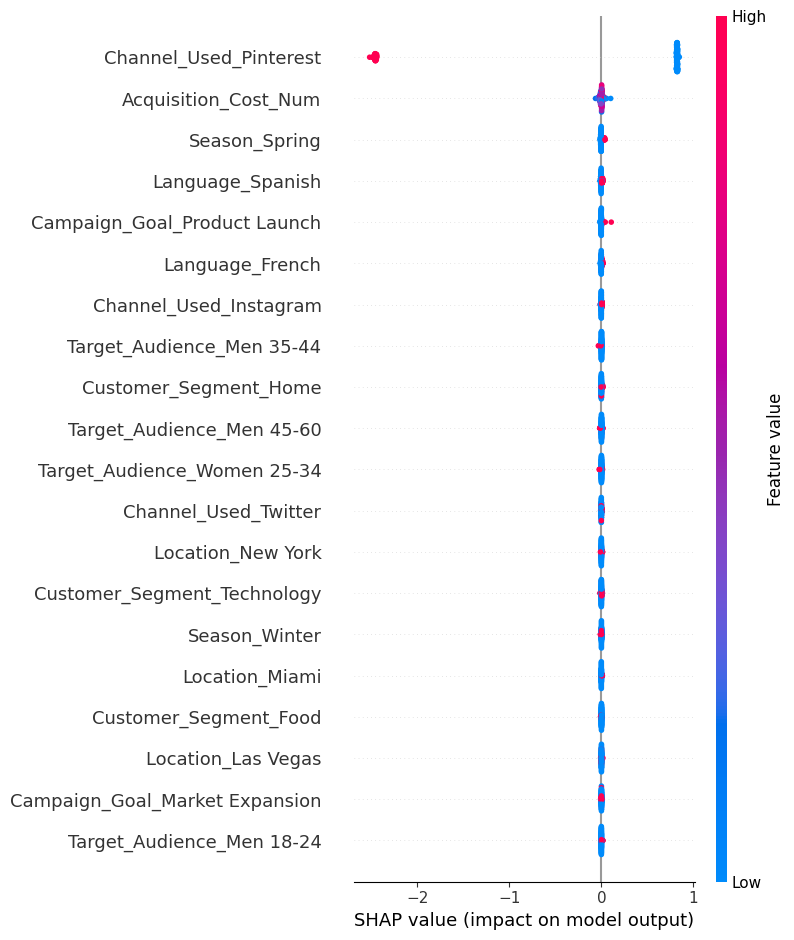

In [21]:
explainer_rf = shap.TreeExplainer(rf_model)
X_test_small = X_test.sample(200, random_state=42)   # try 100–500
shap_values_rf = explainer_rf.shap_values(X_test_small)
shap.summary_plot(shap_values_rf, X_test_small)